# Galsim AutoEncoder demo

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
sys.path.append('../')
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Create a galaxy dataset from GalSim

In [2]:
import galsim

In [3]:
cat = galsim.COSMOSCatalog(dir='/usr/local/share/galsim/COSMOS_25.2_training_sample',
                           file_name='real_galaxy_catalog_25.2.fits')

In [4]:
from deepgal.galsim import get_postage_stamp_map
from multiprocessing import Pool
import tensorflow as tf

In [5]:
pool=None
def training_func():
    dset = tf.data.Dataset.from_tensor_slices(cat.orig_index).batch(128).map(get_postage_stamp_map(cat.real_cat,stamp_size=32, pixel_size=0.06, pool=pool))
    dset = dset.flat_map(lambda arg, *rest: tf.data.Dataset.from_tensor_slices((arg,) + rest))
    dset = dset.repeat(2).cache('/data2/cosmos_cache/cache32')
    dset = dset.repeat().shuffle(buffer_size=20000).batch(64).prefetch(16)
    iterator = dset.make_one_shot_iterator()
    batch_im, batch_psf, batch_ps = iterator.get_next()
    return {'x': tf.clip_by_value(batch_im / 0.003,-300,300), 'psf':batch_psf, 'ps':batch_ps}, tf.clip_by_value(batch_im / 0.003,-300,300)

In [6]:
# def training_func():
#     dset = tf.data.Dataset.from_tensor_slices(cat.orig_index[0:256]).batch(128).map(get_postage_stamp_map(cat.real_cat,stamp_size=32, pixel_size=0.06, pool=pool))
#     dset = dset.flat_map(lambda arg, *rest: tf.data.Dataset.from_tensor_slices((arg,) + rest))
#     dset = dset.batch(16)
#     iterator = dset.make_one_shot_iterator()
#     batch_im, batch_psf, batch_ps = iterator.get_next()
#     return {'x': tf.clip_by_value(batch_im / 0.003,-300,300), 'psf':batch_psf, 'ps':batch_ps}, tf.clip_by_value(batch_im / 0.003,-300,300)

## Builds VAE model

In [7]:
from deepgal.VAEEstimator import VAEEstimator
from deepgal.nets import resnet_encoder, resnet_generator

In [8]:
# Compute a likelihood function
def GaussianLikelihood(x, y, features):
    size = x.get_shape().as_list()[1]
    
    x = tf.squeeze(x) #tf.spectral.rfft2d(tf.squeeze(x))
    y = tf.squeeze(y) #tf.spectral.rfft2d(tf.squeeze(y))
    
    # Apply PSF to y
    #y = y * features['psf']
    
    #ps = features['ps']
    #ps = tf.where(tf.greater(ps, 5), ps, ps*0 + tf.reduce_min(ps,keep_dims=True))
    
    # Compute log likelihood
    pz = tf.abs(x - y)**2 #/ (2 * tf.exp(ps)/0.003**2)
    
    # Apply normalisation
    #pz /= size**2
    pz = tf.reduce_sum(tf.squeeze(pz), axis=[-1,-2])
    return -pz

In [9]:
import functools
stamp_size=32
latent_size=16

In [10]:
model = VAEEstimator(encoder_fn=resnet_encoder, decoder_fn=resnet_generator, loglikelihood_fn=GaussianLikelihood,
                     latent_size=latent_size, learning_rate=0.0001, model_dir='/data2/DeepGal/cosmos/vae_32e')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data2/DeepGal/cosmos/vae_32e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc4eabeb4e0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
model.train(training_func, steps=100000)

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/DeepGal/cosmos/vae_32e/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /data2/DeepGal/cosmos/vae_32e/model.ckpt.
INFO:tensorflow:loss = 629881.25, step = 0
INFO:tensorflow:global_step/sec: 5.20392
INFO:tensorflow:loss = 73676.38, step = 100 (19.219 sec)
INFO:tensorflow:global_step/sec: 5.40111
INFO:tensorflow:loss = 57239.05, step = 200 (18.514 sec)
INFO:tensorflow:global_step/sec: 5.34719
INFO:tensorflow:loss = 49971.11, step = 300 (18.701 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 5.13909
INFO:tensorflow:loss = 46982.74, step = 7500 (19.460 sec)
INFO:tensorflow:global_step/sec: 5.18728
INFO:tensorflow:loss = 41634.457, step = 7600 (19.277 sec)
INFO:tensorflow:global_step/sec: 4.88962
INFO:tensorflow:loss = 40522.14, step = 7700 (20.452 sec)
INFO:tensorflow:global_step/sec: 5.25235
INFO:tensorflow:loss = 65764.086, step = 7800 (19.040 sec)
INFO:tensorflow:global_step/sec: 4.92814
INFO:tensorflow:loss = 47472.977, step = 7900 (20.292 sec)
INFO:tensorflow:global_step/sec: 5.08719
INFO:tensorflow:loss = 34433.47, step = 8000 (19.657 sec)
INFO:tensorflow:global_step/sec: 5.03304
INFO:tensorflow:loss = 45617.387, step = 8100 (19.870 sec)
INFO:tensorflow:global_step/sec: 5.01135
INFO:tensorflow:loss = 45792.03, step = 8200 (19.953 sec)
INFO:tensorflow:global_step/sec: 5.16467
INFO:tensorflow:loss = 36129.812, step = 8300 (19.364 sec)
INFO:tensorflow:global_step/sec: 4.88011
INFO:tensorflow:loss = 34526.633, step = 8400 (20.492 sec)
INFO

INFO:tensorflow:loss = 36751.617, step = 15400 (19.462 sec)
INFO:tensorflow:global_step/sec: 5.07137
INFO:tensorflow:loss = 36460.05, step = 15500 (19.719 sec)
INFO:tensorflow:global_step/sec: 4.94943
INFO:tensorflow:loss = 39435.516, step = 15600 (20.204 sec)
INFO:tensorflow:global_step/sec: 5.0323
INFO:tensorflow:loss = 47792.5, step = 15700 (19.871 sec)
INFO:tensorflow:global_step/sec: 4.9143
INFO:tensorflow:loss = 37755.2, step = 15800 (20.349 sec)
INFO:tensorflow:global_step/sec: 5.1748
INFO:tensorflow:loss = 46901.76, step = 15900 (19.324 sec)
INFO:tensorflow:global_step/sec: 4.91426
INFO:tensorflow:loss = 42711.02, step = 16000 (20.349 sec)
INFO:tensorflow:global_step/sec: 5.07055
INFO:tensorflow:loss = 54836.125, step = 16100 (19.722 sec)
INFO:tensorflow:global_step/sec: 4.99667
INFO:tensorflow:loss = 27455.152, step = 16200 (20.014 sec)
INFO:tensorflow:global_step/sec: 5.07259
INFO:tensorflow:loss = 40350.13, step = 16300 (19.712 sec)
INFO:tensorflow:global_step/sec: 5.03285
I

INFO:tensorflow:loss = 39936.383, step = 23400 (19.129 sec)
INFO:tensorflow:global_step/sec: 5.05601
INFO:tensorflow:loss = 31536.082, step = 23500 (19.778 sec)
INFO:tensorflow:global_step/sec: 5.05517
INFO:tensorflow:loss = 38468.812, step = 23600 (19.782 sec)
INFO:tensorflow:global_step/sec: 5.10069
INFO:tensorflow:loss = 31102.035, step = 23700 (19.605 sec)
INFO:tensorflow:global_step/sec: 5.15707
INFO:tensorflow:loss = 45121.645, step = 23800 (19.391 sec)
INFO:tensorflow:global_step/sec: 4.89171
INFO:tensorflow:loss = 42642.22, step = 23900 (20.442 sec)
INFO:tensorflow:global_step/sec: 5.23556
INFO:tensorflow:loss = 54660.62, step = 24000 (19.101 sec)
INFO:tensorflow:global_step/sec: 4.93603
INFO:tensorflow:loss = 37310.926, step = 24100 (20.258 sec)
INFO:tensorflow:Saving checkpoints for 24139 into /data2/DeepGal/cosmos/vae_32e/model.ckpt.
INFO:tensorflow:global_step/sec: 4.23578
INFO:tensorflow:loss = 45980.617, step = 24200 (23.610 sec)
INFO:tensorflow:global_step/sec: 5.0454
IN

INFO:tensorflow:loss = 63381.78, step = 31300 (20.325 sec)
INFO:tensorflow:global_step/sec: 5.08082
INFO:tensorflow:loss = 33146.027, step = 31400 (19.681 sec)
INFO:tensorflow:global_step/sec: 5.10397
INFO:tensorflow:loss = 43219.734, step = 31500 (19.593 sec)
INFO:tensorflow:global_step/sec: 4.98231
INFO:tensorflow:loss = 48558.234, step = 31600 (20.071 sec)
INFO:tensorflow:global_step/sec: 4.98076
INFO:tensorflow:loss = 50659.945, step = 31700 (20.077 sec)
INFO:tensorflow:global_step/sec: 5.19874
INFO:tensorflow:loss = 41415.17, step = 31800 (19.235 sec)
INFO:tensorflow:global_step/sec: 4.96272
INFO:tensorflow:loss = 40647.816, step = 31900 (20.150 sec)
INFO:tensorflow:global_step/sec: 5.05441
INFO:tensorflow:loss = 40868.812, step = 32000 (19.785 sec)
INFO:tensorflow:global_step/sec: 4.99884
INFO:tensorflow:loss = 38625.348, step = 32100 (20.005 sec)
INFO:tensorflow:global_step/sec: 5.09312
INFO:tensorflow:loss = 43645.35, step = 32200 (19.634 sec)
INFO:tensorflow:global_step/sec: 5

INFO:tensorflow:global_step/sec: 4.27666
INFO:tensorflow:loss = 37719.785, step = 39300 (23.382 sec)
INFO:tensorflow:global_step/sec: 5.23062
INFO:tensorflow:loss = 35510.88, step = 39400 (19.118 sec)
INFO:tensorflow:global_step/sec: 4.99931
INFO:tensorflow:loss = 41776.695, step = 39500 (20.003 sec)
INFO:tensorflow:global_step/sec: 5.17268
INFO:tensorflow:loss = 46364.418, step = 39600 (19.333 sec)
INFO:tensorflow:global_step/sec: 5.05815
INFO:tensorflow:loss = 32268.809, step = 39700 (19.771 sec)
INFO:tensorflow:global_step/sec: 5.0669
INFO:tensorflow:loss = 39181.273, step = 39800 (19.734 sec)
INFO:tensorflow:global_step/sec: 5.10381
INFO:tensorflow:loss = 50657.016, step = 39900 (19.594 sec)
INFO:tensorflow:global_step/sec: 5.14182
INFO:tensorflow:loss = 56807.17, step = 40000 (19.448 sec)
INFO:tensorflow:global_step/sec: 5.03251
INFO:tensorflow:loss = 34980.13, step = 40100 (19.873 sec)
INFO:tensorflow:global_step/sec: 5.16
INFO:tensorflow:loss = 47187.562, step = 40200 (19.379 se

INFO:tensorflow:global_step/sec: 5.0845
INFO:tensorflow:loss = 32955.637, step = 47300 (19.673 sec)
INFO:tensorflow:global_step/sec: 5.17194
INFO:tensorflow:loss = 36667.45, step = 47400 (19.332 sec)
INFO:tensorflow:global_step/sec: 4.9763
INFO:tensorflow:loss = 64696.734, step = 47500 (20.093 sec)
INFO:tensorflow:global_step/sec: 5.23713
INFO:tensorflow:loss = 37408.613, step = 47600 (19.097 sec)
INFO:tensorflow:global_step/sec: 5.09926
INFO:tensorflow:loss = 37315.17, step = 47700 (19.609 sec)
INFO:tensorflow:global_step/sec: 5.01118
INFO:tensorflow:loss = 43163.703, step = 47800 (19.956 sec)
INFO:tensorflow:global_step/sec: 5.22709
INFO:tensorflow:loss = 48081.305, step = 47900 (19.131 sec)
INFO:tensorflow:global_step/sec: 4.93017
INFO:tensorflow:loss = 50424.71, step = 48000 (20.283 sec)
INFO:tensorflow:global_step/sec: 5.2527
INFO:tensorflow:loss = 32411.29, step = 48100 (19.038 sec)
INFO:tensorflow:global_step/sec: 4.97247
INFO:tensorflow:loss = 40241.668, step = 48200 (20.111 se

INFO:tensorflow:global_step/sec: 4.98463
INFO:tensorflow:loss = 36376.79, step = 55200 (20.060 sec)
INFO:tensorflow:global_step/sec: 5.07908
INFO:tensorflow:loss = 44514.727, step = 55300 (19.689 sec)
INFO:tensorflow:global_step/sec: 5.01297
INFO:tensorflow:loss = 42377.125, step = 55400 (19.949 sec)
INFO:tensorflow:global_step/sec: 5.10893
INFO:tensorflow:loss = 44274.746, step = 55500 (19.572 sec)
INFO:tensorflow:global_step/sec: 5.09465
INFO:tensorflow:loss = 44642.23, step = 55600 (19.630 sec)
INFO:tensorflow:global_step/sec: 5.02634
INFO:tensorflow:loss = 35348.902, step = 55700 (19.895 sec)
INFO:tensorflow:global_step/sec: 4.98186
INFO:tensorflow:loss = 36135.523, step = 55800 (20.074 sec)
INFO:tensorflow:global_step/sec: 5.19527
INFO:tensorflow:loss = 32560.8, step = 55900 (19.246 sec)
INFO:tensorflow:global_step/sec: 5.08786
INFO:tensorflow:loss = 39694.684, step = 56000 (19.655 sec)
INFO:tensorflow:global_step/sec: 5.04732
INFO:tensorflow:loss = 45263.992, step = 56100 (19.813

INFO:tensorflow:global_step/sec: 5.13609
INFO:tensorflow:loss = 48143.414, step = 63200 (19.470 sec)
INFO:tensorflow:global_step/sec: 4.88796
INFO:tensorflow:loss = 28635.447, step = 63300 (20.458 sec)
INFO:tensorflow:global_step/sec: 5.2965
INFO:tensorflow:loss = 43673.56, step = 63400 (18.880 sec)
INFO:tensorflow:Saving checkpoints for 63458 into /data2/DeepGal/cosmos/vae_32e/model.ckpt.
INFO:tensorflow:global_step/sec: 4.17909
INFO:tensorflow:loss = 39684.652, step = 63500 (23.929 sec)
INFO:tensorflow:global_step/sec: 5.18796
INFO:tensorflow:loss = 45389.367, step = 63600 (19.275 sec)
INFO:tensorflow:global_step/sec: 5.16777
INFO:tensorflow:loss = 43589.742, step = 63700 (19.350 sec)
INFO:tensorflow:global_step/sec: 4.925
INFO:tensorflow:loss = 50792.168, step = 63800 (20.306 sec)
INFO:tensorflow:global_step/sec: 5.01418
INFO:tensorflow:loss = 31866.012, step = 63900 (19.942 sec)
INFO:tensorflow:global_step/sec: 5.13782
INFO:tensorflow:loss = 54543.094, step = 64000 (19.464 sec)
INF

INFO:tensorflow:global_step/sec: 4.94488
INFO:tensorflow:loss = 41694.723, step = 71100 (20.224 sec)
INFO:tensorflow:global_step/sec: 5.27231
INFO:tensorflow:loss = 41295.863, step = 71200 (18.968 sec)
INFO:tensorflow:global_step/sec: 5.12509
INFO:tensorflow:loss = 44765.527, step = 71300 (19.511 sec)
INFO:tensorflow:global_step/sec: 5.03707
INFO:tensorflow:loss = 37423.21, step = 71400 (19.853 sec)
INFO:tensorflow:global_step/sec: 5.17641
INFO:tensorflow:loss = 73452.49, step = 71500 (19.319 sec)
INFO:tensorflow:global_step/sec: 5.06553
INFO:tensorflow:loss = 34677.375, step = 71600 (19.741 sec)
INFO:tensorflow:global_step/sec: 5.07002
INFO:tensorflow:loss = 38462.086, step = 71700 (19.724 sec)
INFO:tensorflow:global_step/sec: 5.09997
INFO:tensorflow:loss = 36577.33, step = 71800 (19.608 sec)
INFO:tensorflow:global_step/sec: 5.06716
INFO:tensorflow:loss = 64134.242, step = 71900 (19.735 sec)
INFO:tensorflow:global_step/sec: 5.03309
INFO:tensorflow:loss = 47757.164, step = 72000 (19.86

INFO:tensorflow:global_step/sec: 5.11163
INFO:tensorflow:loss = 44291.51, step = 79000 (19.562 sec)
INFO:tensorflow:global_step/sec: 5.08113
INFO:tensorflow:loss = 36018.742, step = 79100 (19.682 sec)
INFO:tensorflow:global_step/sec: 5.08522
INFO:tensorflow:loss = 37790.125, step = 79200 (19.666 sec)
INFO:tensorflow:global_step/sec: 5.00731
INFO:tensorflow:loss = 40986.05, step = 79300 (19.970 sec)
INFO:tensorflow:global_step/sec: 5.0303
INFO:tensorflow:loss = 42798.74, step = 79400 (19.880 sec)
INFO:tensorflow:global_step/sec: 5.13798
INFO:tensorflow:loss = 36203.754, step = 79500 (19.461 sec)
INFO:tensorflow:global_step/sec: 5.0886
INFO:tensorflow:loss = 38559.234, step = 79600 (19.653 sec)
INFO:tensorflow:global_step/sec: 5.14249
INFO:tensorflow:loss = 62163.98, step = 79700 (19.446 sec)
INFO:tensorflow:global_step/sec: 5.03223
INFO:tensorflow:loss = 39206.34, step = 79800 (19.872 sec)
INFO:tensorflow:global_step/sec: 4.9729
INFO:tensorflow:loss = 49638.066, step = 79900 (20.107 sec

INFO:tensorflow:global_step/sec: 5.09889
INFO:tensorflow:loss = 52313.37, step = 87000 (19.612 sec)
INFO:tensorflow:global_step/sec: 4.98183
INFO:tensorflow:loss = 39338.734, step = 87100 (20.072 sec)
INFO:tensorflow:global_step/sec: 5.08514
INFO:tensorflow:loss = 37948.832, step = 87200 (19.667 sec)
INFO:tensorflow:global_step/sec: 5.1974
INFO:tensorflow:loss = 43897.63, step = 87300 (19.238 sec)
INFO:tensorflow:global_step/sec: 5.13734
INFO:tensorflow:loss = 47973.06, step = 87400 (19.466 sec)
INFO:tensorflow:global_step/sec: 5.13526
INFO:tensorflow:loss = 75548.35, step = 87500 (19.474 sec)
INFO:tensorflow:global_step/sec: 4.98612
INFO:tensorflow:loss = 53074.984, step = 87600 (20.054 sec)
INFO:tensorflow:Saving checkpoints for 87647 into /data2/DeepGal/cosmos/vae_32e/model.ckpt.
INFO:tensorflow:global_step/sec: 4.26206
INFO:tensorflow:loss = 80468.81, step = 87700 (23.464 sec)
INFO:tensorflow:global_step/sec: 5.17279
INFO:tensorflow:loss = 49785.332, step = 87800 (19.332 sec)
INFO:

INFO:tensorflow:global_step/sec: 5.01651
INFO:tensorflow:loss = 53667.36, step = 94900 (19.934 sec)
INFO:tensorflow:global_step/sec: 5.01857
INFO:tensorflow:loss = 52201.016, step = 95000 (19.925 sec)
INFO:tensorflow:global_step/sec: 5.07427
INFO:tensorflow:loss = 45325.105, step = 95100 (19.707 sec)
INFO:tensorflow:global_step/sec: 5.07735
INFO:tensorflow:loss = 36559.453, step = 95200 (19.697 sec)
INFO:tensorflow:global_step/sec: 5.09639
INFO:tensorflow:loss = 42000.234, step = 95300 (19.622 sec)
INFO:tensorflow:global_step/sec: 5.13169
INFO:tensorflow:loss = 35502.047, step = 95400 (19.487 sec)
INFO:tensorflow:global_step/sec: 4.98744
INFO:tensorflow:loss = 30144.805, step = 95500 (20.050 sec)
INFO:tensorflow:global_step/sec: 5.13022
INFO:tensorflow:loss = 49786.004, step = 95600 (19.492 sec)
INFO:tensorflow:global_step/sec: 5.03178
INFO:tensorflow:loss = 38901.406, step = 95700 (19.876 sec)
INFO:tensorflow:global_step/sec: 5.14208
INFO:tensorflow:loss = 29086.102, step = 95800 (19.

In [17]:
# Exports module
import tensorflow_hub as hub
image = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='input_image')
sample_shape = tf.placeholder(tf.int32, name='sample_shape')
code = tf.placeholder(tf.float32, shape=[None, latent_size], name='code')

exporter = hub.LatestModuleExporter("tf_hub", 
                                    tf.estimator.export.build_raw_serving_input_receiver_fn({'x':image, 
                                                                                             'sample_shape':sample_shape,
                                                                                             'code':code},
                                                                   default_batch_size=None))

In [18]:
exporter.export(model, 'models', model.latest_checkpoint())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Restoring parameters from /data2/DeepGal/cosmos/vae_32e/model.ckpt-100000
INFO:tensorflow:Exported TF-Hub module to: b"models/temp-b'1544402355'/encoder"
INFO:tensorflow:Exported TF-Hub module to: b"models/temp-b'1544402355'/decoder"


b'models/1544402355'

In [33]:
decoder = hub.Module('models/1544402355/decoder')
encoder = hub.Module('models/1544402355/encoder')

In [21]:
code = randn(16,latent_size)

In [27]:
rec = module(code)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [37]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    _, im = training_func()
    code = encoder({'image':im, 'sample_shape':1}, as_dict=True)
    recon = module(tf.squeeze(code['sample']))
    rec,imin = sess.run([recon, im])

/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


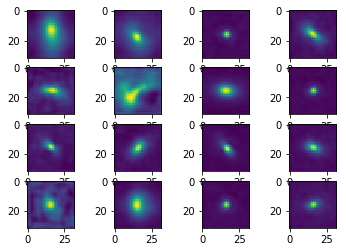

In [39]:
for i in range(16):
    subplot(4,4,i+1)
    imshow(rec[i,:,:,0])

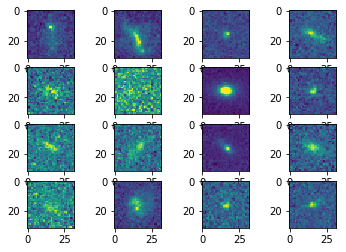

In [38]:
for i in range(16):
    subplot(4,4,i+1)
    imshow(imin[i,:,:,0])

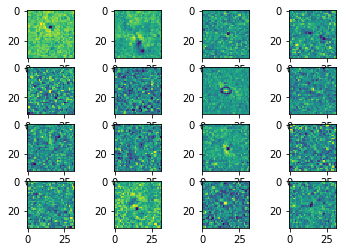

In [40]:
for i in range(16):
    subplot(4,4,i+1)
    imshow(rec[i,:,:,0] - imin[i,:,:,0])

## Train code manipulation code

In [65]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import tensorflow_hub as hub



In [12]:
tf.reset_default_graph()

In [131]:
p1 = permutation(latent_size)
chain = tfb.Chain([tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
            hidden_layers=[512, 512])),
                   tfb.Permute(permutation=p1),
    tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
            hidden_layers=[512, 512]))])
maf = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=np.zeros(latent_size, dtype='float32')),
    bijector=chain)

In [132]:
maf = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=np.zeros(latent_size, dtype='float32')),
    bijector=chain)

In [77]:
nvp = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=np.zeros(latent_size, dtype='float32')),
    bijector=tfb.RealNVP(
        num_masked=2,
        shift_and_log_scale_fn=tfb.real_nvp_default_template(
            hidden_layers=[512, 512])))

In [133]:
sess = tf.Session()
decoder = hub.Module('models/1544402355/decoder', trainable=False)
encoder = hub.Module('models/1544402355/encoder', trainable=False)


In [135]:
_,im = training_func()

/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [169]:
lr = tf.placeholder(tf.float32, shape=())
code = encoder( {'image':im, 'sample_shape':100} , as_dict=True)['sample']
loss = - tf.reduce_mean(maf.log_prob(code))

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(loss)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [170]:
sess.run(tf.global_variables_initializer())
losses = []

In [176]:
for i in range(1000):
    l, _ = sess.run([loss, opt_op], feed_dict={lr:0.001})
    losses.append(l)
    if i %100 ==0:
        print(l)

22.890297
23.986032
21.119722
16.807343
20.334578
20.374763
15.501745
19.473764
18.462147
18.704365


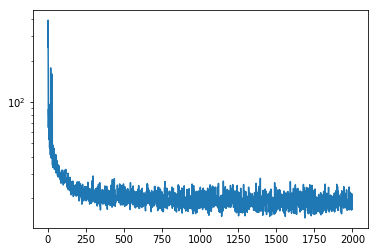

In [177]:
plot(losses)
yscale('log')

In [178]:
s = sess.run(maf.sample(sample_shape=6000))

codes = []
for i in range(100):
    c = sess.run(code)
    codes.append(c[0])
codes = concatenate(codes)

In [179]:
print(s.shape)
print(c.shape)

(6000, 16)
(100, 64, 16)


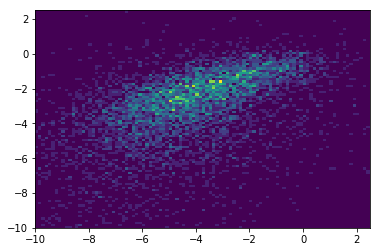

In [180]:
hist2d(s[:,0],s[:,1],100,[[-10,2.5],[-10,2.5]]);

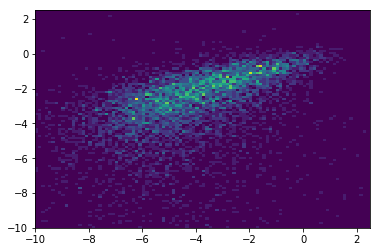

In [168]:
hist2d(codes[:,0],codes[:,1],100,[[-10,2.5],[-10,2.5]]);

## Now try to sample from learned posterior

In [185]:
recon = decoder(maf.sample(16))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [186]:
r = sess.run(recon)

In [187]:
r.shape

(16, 32, 32, 1)

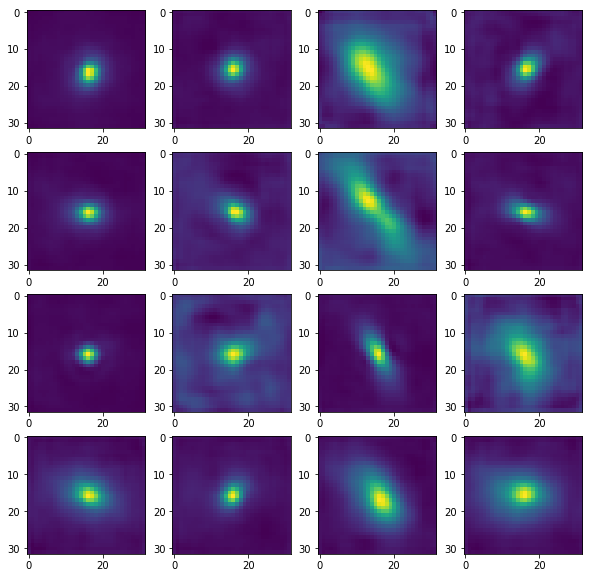

In [189]:
figure(figsize=(10,10))
for i in range(16):
    subplot(4,4, i+1)
    imshow(r[i,:,:,0])

### Now trying to train a conditional code sampler

In [13]:
def training_func_conditional():
    dset_indices = tf.data.Dataset.from_tensor_slices(cat.orig_index)
    dset_radius = tf.data.Dataset.from_tensor_slices(cat.param_cat['flux_radius'][cat.orig_index].astype('float32'))
    dset = dset_indices.batch(128).map(get_postage_stamp_map(cat.real_cat,stamp_size=32, pixel_size=0.06, pool=pool))
    dset = dset.flat_map(lambda arg, *rest: tf.data.Dataset.from_tensor_slices((arg,) + rest))
    dset = dset.repeat(2).cache('/data2/cosmos_cache/cache32')
    dset = tf.data.Dataset.zip((dset, dset_radius.repeat(2)))
    dset = dset.repeat().shuffle(buffer_size=20000).batch(64).prefetch(16)
    iterator = dset.make_one_shot_iterator()
    (batch_im, batch_psf, batch_ps), batch_size = iterator.get_next()
    return {'x': tf.clip_by_value(batch_im / 0.003,-300,300), 'psf':batch_psf, 'ps':batch_ps, 'size':batch_size}, tf.clip_by_value(batch_im / 0.003,-300,300)

In [22]:
def real_nvp_conditional_template(hidden_layers,
                                  conditional_tensor,
                                  shift_only=False,
                                  activation=tf.nn.relu,
                                  name=None,
                                  *args,  # pylint: disable=keyword-arg-before-vararg
                                  **kwargs):
  """Build a scale-and-shift function using a multi-layer neural network.
  This will be wrapped in a make_template to ensure the variables are only
  created once. It takes the `d`-dimensional input x[0:d] and returns the `D-d`
  dimensional outputs `loc` ("mu") and `log_scale` ("alpha").
  The default template does not support conditioning and will raise an
  exception if `condition_kwargs` are passed to it. To use conditioning in
  real nvp bijector, implement a conditioned shift/scale template that
  handles the `condition_kwargs`.
  Arguments:
    hidden_layers: Python `list`-like of non-negative integer, scalars
      indicating the number of units in each hidden layer. Default: `[512, 512].
    shift_only: Python `bool` indicating if only the `shift` term shall be
      computed (i.e. NICE bijector). Default: `False`.
    activation: Activation function (callable). Explicitly setting to `None`
      implies a linear activation.
    name: A name for ops managed by this function. Default:
      "real_nvp_default_template".
    *args: `tf.layers.dense` arguments.
    **kwargs: `tf.layers.dense` keyword arguments.
  Returns:
    shift: `Float`-like `Tensor` of shift terms ("mu" in
      [Papamakarios et al.  (2016)][1]).
    log_scale: `Float`-like `Tensor` of log(scale) terms ("alpha" in
      [Papamakarios et al. (2016)][1]).
  Raises:
    NotImplementedError: if rightmost dimension of `inputs` is unknown prior to
      graph execution, or if `condition_kwargs` is not empty.
  #### References
  [1]: George Papamakarios, Theo Pavlakou, and Iain Murray. Masked
       Autoregressive Flow for Density Estimation. In _Neural Information
       Processing Systems_, 2017. https://arxiv.org/abs/1705.07057
  """

  with tf.name_scope(name, "real_nvp_conditional_template"):

    def _fn(x, output_units, **condition_kwargs):
      """Fully connected MLP parameterized via `real_nvp_template`."""
      if condition_kwargs:
        raise NotImplementedError(
            "Conditioning not implemented in the default template.")

      if len(x.shape) == 1:
        x = x[tf.newaxis, ...]
        reshape_output = lambda x: x[0]
      else:
        reshape_output = lambda x: x
      x = tf.concat([x, conditional_tensor], axis=1)
      for units in hidden_layers:
        x = tf.layers.dense(
            inputs=x,
            units=units,
            activation=activation,
            *args,  # pylint: disable=keyword-arg-before-vararg
            **kwargs)
      x = tf.layers.dense(
          inputs=x,
          units=(1 if shift_only else 2) * output_units,
          activation=None,
          *args,  # pylint: disable=keyword-arg-before-vararg
          **kwargs)
      if shift_only:
        return reshape_output(x), None
      shift, log_scale = tf.split(x, 2, axis=-1)
      return reshape_output(shift), reshape_output(log_scale)

    return tf.make_template("real_nvp_default_template", _fn)

In [108]:
def masked_autoregressive_conditional_template(hidden_layers,
                                            conditional_tensor,
                                           shift_only=False,
                                           activation=tf.nn.relu,
                                           log_scale_min_clip=-5.,
                                           log_scale_max_clip=3.,
                                           log_scale_clip_gradient=False,
                                           name=None,
                                           *args,  # pylint: disable=keyword-arg-before-vararg
                                           **kwargs):
  name = name or "masked_autoregressive_default_template"
  with tf.name_scope(name, values=[log_scale_min_clip, log_scale_max_clip]):
    def _fn(x):
      """MADE parameterized via `masked_autoregressive_default_template`."""
      # TODO(b/67594795): Better support of dynamic shape.
        
      input_shape = (
          np.int32(x.shape.as_list())
          if x.shape.is_fully_defined() else tf.shape(x))
      if len(x.shape) == 1:
        x = x[tf.newaxis, ...]
        

      x = tf.concat([conditional_tensor, x],  axis=1)
      cond_depth = conditional_tensor.shape.with_rank_at_least(1)[-1].value
      input_depth = x.shape.with_rank_at_least(1)[-1].value
    
      if input_depth is None:
        raise NotImplementedError(
            "Rightmost dimension must be known prior to graph execution.")
        
      for i, units in enumerate(hidden_layers):
        x = tfb.masked_dense(
            inputs=x,
            units=units,
            num_blocks=input_depth,
            exclusive=True if i == 0 else False,
            activation=activation,
            *args,  # pylint: disable=keyword-arg-before-vararg
            **kwargs)
        
      x = tfb.masked_dense(
          inputs=x,
          units=(1 if shift_only else 2) * input_depth,
          num_blocks=input_depth,
          activation=None,
          *args,  # pylint: disable=keyword-arg-before-vararg
          **kwargs)
    
      if shift_only:
        x = x[:, cond_depth:]
        x = tf.reshape(x, shape=input_shape)
        return x, None
      else:
        x = x[:, 2*cond_depth:]
      x = tf.reshape(x, shape=tf.concat([input_shape, [2]], axis=0))
      shift, log_scale = tf.unstack(x, num=2, axis=-1)
      which_clip = (
          tf.clip_by_value
          if log_scale_clip_gradient else _clip_by_value_preserve_grad)
      log_scale = which_clip(log_scale, log_scale_min_clip, log_scale_max_clip)
      return shift, log_scale

    return tf.make_template(name, _fn)

def _clip_by_value_preserve_grad(x, clip_value_min, clip_value_max, name=None):
  """Clips input while leaving gradient unaltered."""
  with tf.name_scope(name, "clip_by_value_preserve_grad",
                     [x, clip_value_min, clip_value_max]):
    clip_x = tf.clip_by_value(x, clip_value_min, clip_value_max)
    return x + tf.stop_gradient(clip_x - x)

In [117]:
tf.reset_default_graph()

In [118]:
a,b = training_func_conditional()
cond = tf.expand_dims(tf.clip_by_value(a['size']/10, 0, 3),1)

p1 = permutation(latent_size)
chain = tfb.Chain([tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=masked_autoregressive_conditional_template(
            hidden_layers=[512, 512],
            conditional_tensor=cond)),
            tfb.Permute(permutation=p1),
    tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=masked_autoregressive_conditional_template(
            hidden_layers=[512, 512],
            conditional_tensor=cond))])
maf = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=np.zeros(latent_size, dtype='float32')),
    bijector=chain)


/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [119]:
decoder = hub.Module('models/1544402355/decoder', trainable=False)
encoder = hub.Module('models/1544402355/encoder', trainable=False)
lr = tf.placeholder(tf.float32, shape=())

code = encoder({'image':a['x'], 'sample_shape':1} , as_dict=True)['sample'][0]
loss = - tf.reduce_mean(maf.log_prob(code))

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(loss)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [123]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses = []

In [124]:
sess.run(loss)

1232.7468

In [127]:
for i in range(1000):
    l, _ = sess.run([loss, opt_op], feed_dict={lr:0.0005})
    losses.append(l)
    if i %100 ==0:
        print(l)

24.425222
27.202673
17.715157
19.051304
18.102436
22.748314
18.080555
17.959152
17.324394
17.412804


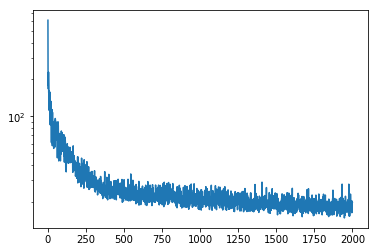

In [128]:
plot(losses)
yscale('log')

In [134]:
codes = []
s = []
sizes=[]
for i in range(100):
    c,ss,si = sess.run([code,maf.sample(sample_shape=64),cond])
    codes.append(c)
    s.append(ss)
    sizes.append(si)

In [135]:
codes = concatenate(codes)
s = concatenate(s)
sizes = concatenate(sizes)

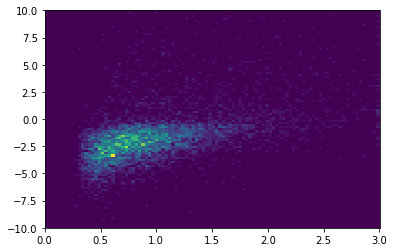

In [143]:
hist2d(sizes[:,0],codes[:,4],100,[[0,3],[-10,10]]);

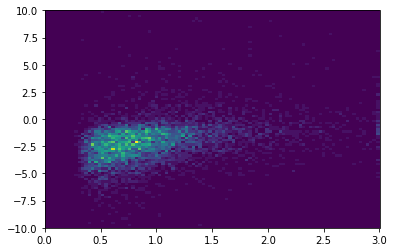

In [145]:
hist2d(sizes[:,0],s[:,4],100,[[0,3],[-10,10]]);

### Let's generate a few images by code manipulation \o/

In [156]:
im,si = sess.run([decoder(maf.sample(sample_shape=64)), cond])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


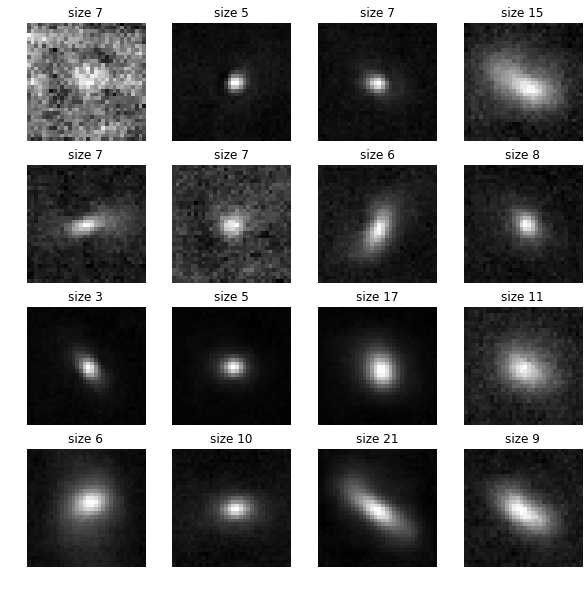

In [157]:
noise = galsim.getCOSMOSNoise()
figure(figsize=(10,10))
for i in range(16):
    subplot(4,4, i+1)
    img = galsim.ImageF(32,32,scale=0.06)
    img.addNoise(noise)
    imshow(im[i,:,:,0]*0.003+img.array, cmap='gray')
    axis('off')
    title('size %d'%(si[i]*10))